In [79]:
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
import pandas as pd
%matplotlib inline

In [4]:
data0 = tf.keras.datasets.mnist
data_mnist = data0.load_data()

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### Build Point in Image

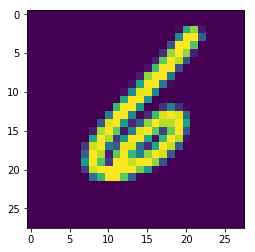

In [25]:
example_img = x_train[999]
plt.imshow(example_img)

In [99]:
input_shape

(28, 28, 1)

In [26]:
# derives a point in image
Y, X = my_og
where_x = np.where(example_img>0, X, 999)
where_y = np.where(example_img>0,Y, 999)
min_x = where_x.min()
min_y = where_y.min()
where_x = np.where(example_img>0, X, -999)
where_y = np.where(example_img>0,Y, -999)
max_x = where_x.max()
max_y = where_y.max()
(min_x, min_y), (max_x, max_y)

((7, 2), (22, 21))

In [ ]:
# explaining ogrid, etc
h, w = example_img.shape[0], example_img.shape[1]
my_og = np.ogrid[:h, :w]
len(my_og), len(my_og[0]), len(my_og[1][0])

In [35]:
def foo(img):
    Y, X = my_og
    where_x = np.where(img>0, X, 999)
    where_y = np.where(img>0, Y, 999)
    min_x = where_x.min()
    min_y = where_y.min()
    where_x = np.where(img>0, X, -999)
    where_y = np.where(img>0,Y, -999)
    max_x = where_x.max()
    max_y = where_y.max()
    min_point, max_point = (min_x, min_y), (max_x, max_y)    
    return min_y

In [41]:
new_truth = [foo(_img) for _img in x_train]
new_truth = np.array(new_truth, dtype='uint8')

In [42]:
print(len(new_truth))
new_truth[:20]

60000


array([ 4,  6,  3,  8,  6,  5, 11,  5, 12,  6,  6,  6,  3,  7, 11,  6,  6,
        7,  9,  7], dtype=uint8)

In [43]:
type(new_truth), type(y_train)

(numpy.ndarray, numpy.ndarray)

### Pre-Training

In [44]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [98]:
tf.__version__

'1.13.1'

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Dropout, 
                                     Flatten, MaxPooling2D)

In [58]:
model = None

In [75]:
# model = Sequential()
# model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
# model.add(Dense(128, activation=tf.nn.relu))
# model.add(Dropout(0.2))
# model.add(Dense(10,activation=tf.nn.softmax))
# model.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# model.fit(x=x_train,y=y_train, epochs=1)

model=Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(1) ) #,activation=tf.nn.softmax))
opt = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer= opt,   #'adam', 
              loss='mean_squared_error', 
              metrics=[ 'mean_absolute_error'
                       ,'mean_squared_error'
                      ]
             )

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 606,233
Trainable params: 606,233
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(x=x_train,y=new_truth, epochs=1)

60000/60000 [==============================] - 41s 677us/sample - loss: 2.3615 - mean_absolute_error: 1.1515 - mean_squared_error: 2.3615- loss: 2.3674 - mean_absolute_error: 1.1530 - mean_squared_error


### Evaluation

In [73]:
avg_truth = sum(new_truth) / len(new_truth)
print('avg y:', avg_truth)
err = [abs(avg_truth - x) for x in new_truth]
mae_avg = sum(err) / len(err)
print ('mae-avg: ', mae_avg)

avg y: 6.604416666666666
mae-avg:  1.6746528472222497


In [90]:
train0 = x_train[0]
test0 = x_test[0]
train0.shape, test0.shape

((28, 28, 1), (28, 28, 1))

In [97]:
tmp = []
for image_index in range(10):
    img = x_test[image_index]
    pred = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1))
#     print(pred)
    tmp.append(pred[0][0])
print(tmp)

[5.417389, 7.738041, 9.70247, 6.5136943, 5.688748, 9.631134, 5.381387, 6.950615, 5.8097663, 6.618882]


In [88]:
model.evaluate(x=x_train,y=new_truth,verbose=0)

[0.7823885952711105, 0.65949184, 0.7823889]

7


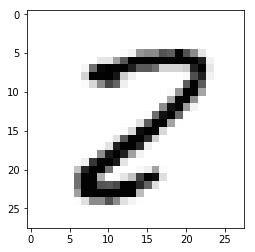

In [68]:
image_index = 444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
img = x_test[image_index]
pred = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1))
print(pred.argmax())

### Perf

In [82]:
history.history

{'loss': [2.361494404602051],
 'mean_absolute_error': [1.1514957],
 'mean_squared_error': [2.3614912]}

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [84]:
hist

,loss,mean_absolute_error,mean_squared_error,epoch
0,2.361494,1.151496,2.361491,0


KeyError: 'val_mean_absolute_error'

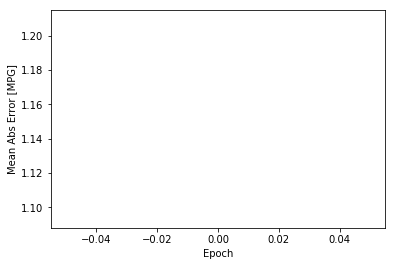

In [80]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
img = x_test[image_index]
pred = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1))
print(pred.argmax())

In [ ]:
def buildModel(input_shape, N=64, learning_rate=0.001):
    
    if input_shape is None:
        return None
    
    model = keras.Sequential([
    
                    keras.layers.Dense (
                                  units=N
                                 ,activation=tf.nn.relu
                                 ,input_shape=input_shape
                                 )
                    ,keras.layers.Dense (
                                  units=N
                                 ,activation=tf.nn.relu
                                 )
                    ,keras.layers.Dense(1)
                    ])
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    
    model.compile(loss='mean_squared_error'
                  ,optimizer=optimizer
                  ,metrics=['mean_absolute_error'
                             ,'mean_squared_error'
                            ]
                 )
    
    return model